In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchsummary import summary
from utils import TrainTest, PlotOutput
from dataset import ACIFAR10
from tqdm import tqdm

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from models.david_page import DavidPageNet

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
device = TrainTest.get_device()
device

'cuda'

In [3]:
# augmentations
# x = datasets.CIFAR10(root='./data', train=True, download=True)

mean = [0.49139968, 0.48215841, 0.44653091] # (x.data.transpose() / 255).reshape(3,-1).mean(-1)
std = [0.24703223, 0.24348513, 0.26158784] # (x.data.transpose() / 255).reshape(3,-1).std(-1)

train_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        A.ToGray(p=0.2),
        A.PadIfNeeded(40, 40, p=1),
        A.RandomCrop(32, 32, p=1),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, fill_value=0, p=1),
        A.Resize(32, 32),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ]
)

In [5]:
# datasets
trainset = ACIFAR10(
    mean=mean, std=std, root='./data', train=True, download=True, transform=train_transform)

testset = ACIFAR10(
    mean=mean, std=std, root='./data', train=False, download=True, transform=test_transform)

# dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


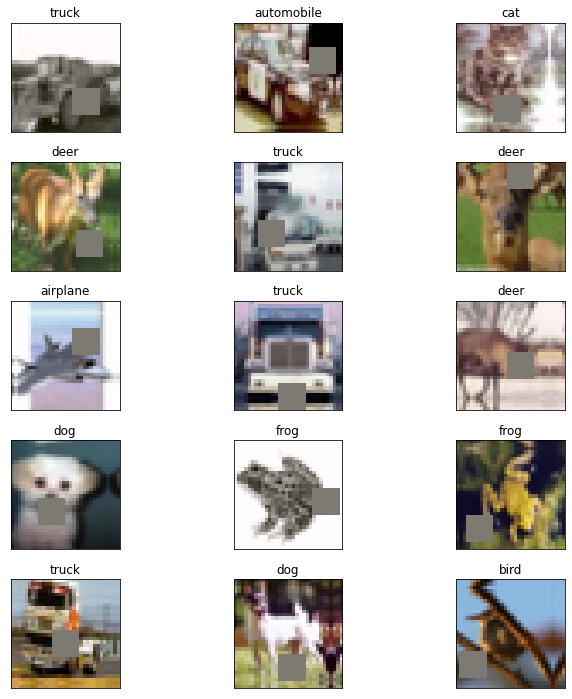

In [6]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10, 10))
batch_data, batch_label = next(iter(train_loader))

t_std = torch.tensor(std).reshape(3, 1, 1)
t_mean = torch.tensor(mean).reshape(3, 1, 1)


for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.tight_layout()

    # get an image - [3, 32, 32]
    # and denormalize
    image = batch_data[i] * t_std + t_mean

    # Clip the input data to the valid range [0, 1]
    image = image.clip(0, 1)
    
    # [3, 32, 32] to [32, 32, 3]
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    
    plt.title(classes[batch_label[i].item()])
    plt.xticks([])
    plt.yticks([])

In [7]:
model = DavidPageNet(dropout=0.).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
          Identity-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1, 128,

In [8]:
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.01)

/home/qblocks/.local/lib/python3.8/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.42E-02


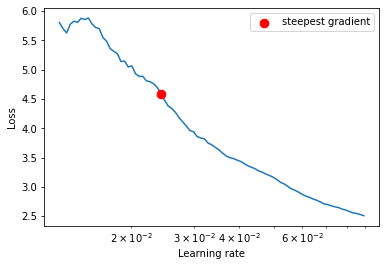

In [9]:
from torch_lr_finder import LRFinder

EPOCHS = 24

def find_lr():
    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=0.1, num_iter=100, step_mode='exp')
    
    _, best_lr = lr_finder.plot()
    lr_finder.reset()
    
    return best_lr 


scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=find_lr(),
            steps_per_epoch=len(train_loader),
            epochs=EPOCHS,
            pct_start=5 / EPOCHS,
            div_factor=100,
            three_phase=False,
            final_div_factor=100,
            anneal_strategy='linear'
        )

In [11]:
target_layers = [model.block3, model.block2]

run = TrainTest(model=model, 
                trainloader=train_loader, 
                testloader=test_loader, 
                optimizer=optimizer, 
                criterion=criterion, 
                scheduler=scheduler,
                target_layers=target_layers)

image_idx = [15, 25, 446, 416, 96]
run(epochs=EPOCHS, cam=True, image_idx=image_idx)
# run.save_grad_cam_gif(image_idx=image_idx, output_directory="./cam_output/")

Train: Loss=1.4557 Batch_id=1562 Accuracy=49.64: 100%|██████████| 1563/1563 [00:21<00:00, 72.62it/s]


Test set: Average loss: 1.0854, Accuracy: 6352/10000 (63.52%)



Train: Loss=1.0079 Batch_id=1562 Accuracy=65.32: 100%|██████████| 1563/1563 [00:20<00:00, 75.92it/s]


Test set: Average loss: 1.0512, Accuracy: 6580/10000 (65.80%)



Train: Loss=0.9169 Batch_id=1562 Accuracy=68.42: 100%|██████████| 1563/1563 [00:21<00:00, 74.28it/s]


Test set: Average loss: 0.7265, Accuracy: 7532/10000 (75.32%)



Train: Loss=0.9074 Batch_id=1562 Accuracy=69.12: 100%|██████████| 1563/1563 [00:21<00:00, 74.03it/s]


Test set: Average loss: 0.7636, Accuracy: 7357/10000 (73.57%)



Train: Loss=0.9260 Batch_id=1562 Accuracy=69.09: 100%|██████████| 1563/1563 [00:21<00:00, 73.69it/s]


Test set: Average loss: 0.7417, Accuracy: 7540/10000 (75.40%)



Train: Loss=0.8645 Batch_id=1562 Accuracy=70.72: 100%|██████████| 1563/1563 [00:21<00:00, 71.48it/s]


Test set: Average loss: 0.7171, Accuracy: 7568/10000 (75.68%)



Train: Loss=0.8032 Batch_id=1562 Accuracy=72.77: 100%|██████████| 1563/1563 [00:21<00:00, 73.83it/s]


Test set: Average loss: 0.6326, Accuracy: 7917/10000 (79.17%)



Train: Loss=0.7351 Batch_id=1562 Accuracy=75.11: 100%|██████████| 1563/1563 [00:21<00:00, 72.55it/s]


Test set: Average loss: 0.6711, Accuracy: 7854/10000 (78.54%)



Train: Loss=0.6851 Batch_id=1562 Accuracy=77.02: 100%|██████████| 1563/1563 [00:20<00:00, 74.44it/s]


Test set: Average loss: 0.5798, Accuracy: 8047/10000 (80.47%)



Train: Loss=0.6445 Batch_id=1562 Accuracy=78.25: 100%|██████████| 1563/1563 [00:21<00:00, 73.12it/s]


Test set: Average loss: 0.5001, Accuracy: 8371/10000 (83.71%)



Train: Loss=0.5977 Batch_id=1562 Accuracy=79.62: 100%|██████████| 1563/1563 [00:21<00:00, 72.63it/s]


Test set: Average loss: 0.4496, Accuracy: 8524/10000 (85.24%)



Train: Loss=0.5593 Batch_id=1562 Accuracy=80.98: 100%|██████████| 1563/1563 [00:21<00:00, 74.13it/s]


Test set: Average loss: 0.4392, Accuracy: 8576/10000 (85.76%)



Train: Loss=0.5203 Batch_id=1562 Accuracy=82.36: 100%|██████████| 1563/1563 [00:21<00:00, 74.23it/s]


Test set: Average loss: 0.4496, Accuracy: 8533/10000 (85.33%)



Train: Loss=0.4898 Batch_id=1562 Accuracy=83.43: 100%|██████████| 1563/1563 [00:21<00:00, 73.13it/s]


Test set: Average loss: 0.4340, Accuracy: 8547/10000 (85.47%)



Train: Loss=0.4593 Batch_id=1562 Accuracy=84.49: 100%|██████████| 1563/1563 [00:20<00:00, 74.49it/s]


Test set: Average loss: 0.3966, Accuracy: 8700/10000 (87.00%)



Train: Loss=0.4317 Batch_id=1562 Accuracy=85.28: 100%|██████████| 1563/1563 [00:21<00:00, 73.21it/s]


Test set: Average loss: 0.3891, Accuracy: 8739/10000 (87.39%)



Train: Loss=0.4031 Batch_id=1562 Accuracy=86.07: 100%|██████████| 1563/1563 [00:20<00:00, 74.71it/s]


Test set: Average loss: 0.3774, Accuracy: 8773/10000 (87.73%)



Train: Loss=0.3822 Batch_id=1562 Accuracy=86.99: 100%|██████████| 1563/1563 [00:20<00:00, 76.08it/s]


Test set: Average loss: 0.3222, Accuracy: 8925/10000 (89.25%)



Train: Loss=0.3529 Batch_id=1562 Accuracy=87.83: 100%|██████████| 1563/1563 [00:21<00:00, 74.35it/s]


Test set: Average loss: 0.3295, Accuracy: 8924/10000 (89.24%)



Train: Loss=0.3337 Batch_id=1562 Accuracy=88.47: 100%|██████████| 1563/1563 [00:21<00:00, 74.03it/s]


Test set: Average loss: 0.3095, Accuracy: 8973/10000 (89.73%)



Train: Loss=0.3112 Batch_id=1562 Accuracy=89.39: 100%|██████████| 1563/1563 [00:20<00:00, 75.88it/s]


Test set: Average loss: 0.3115, Accuracy: 8963/10000 (89.63%)



Train: Loss=0.2943 Batch_id=1562 Accuracy=89.91: 100%|██████████| 1563/1563 [00:21<00:00, 72.35it/s]


Test set: Average loss: 0.2875, Accuracy: 9035/10000 (90.35%)



Train: Loss=0.2755 Batch_id=1562 Accuracy=90.45: 100%|██████████| 1563/1563 [00:21<00:00, 71.97it/s]


Test set: Average loss: 0.2852, Accuracy: 9057/10000 (90.57%)



Train: Loss=0.2598 Batch_id=1562 Accuracy=90.88: 100%|██████████| 1563/1563 [00:22<00:00, 69.44it/s]


Test set: Average loss: 0.2814, Accuracy: 9085/10000 (90.85%)



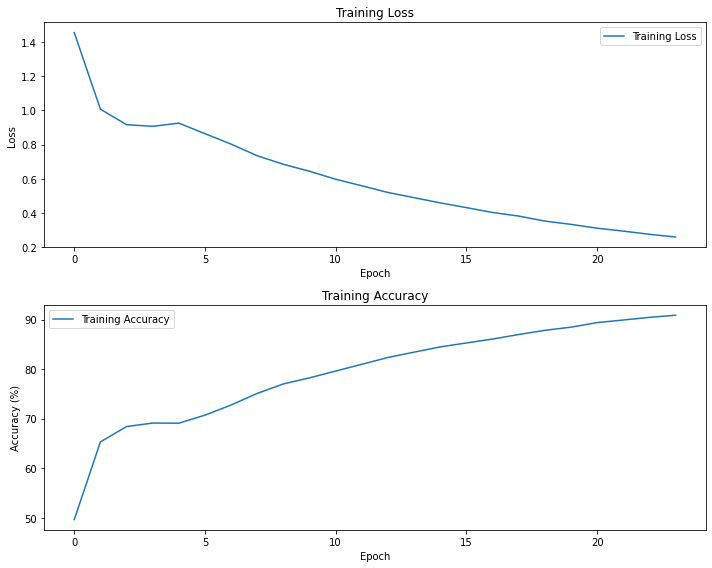

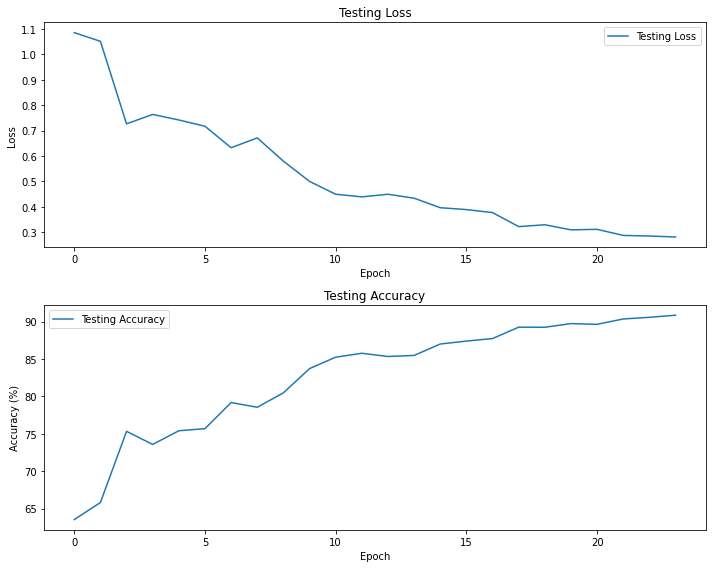

In [12]:
run.train.plot_stats()
run.test.plot_stats()

In [14]:
plot = PlotOutput(model, target_layers=target_layers, device=device)

100%|██████████| 313/313 [00:02<00:00, 128.53it/s]


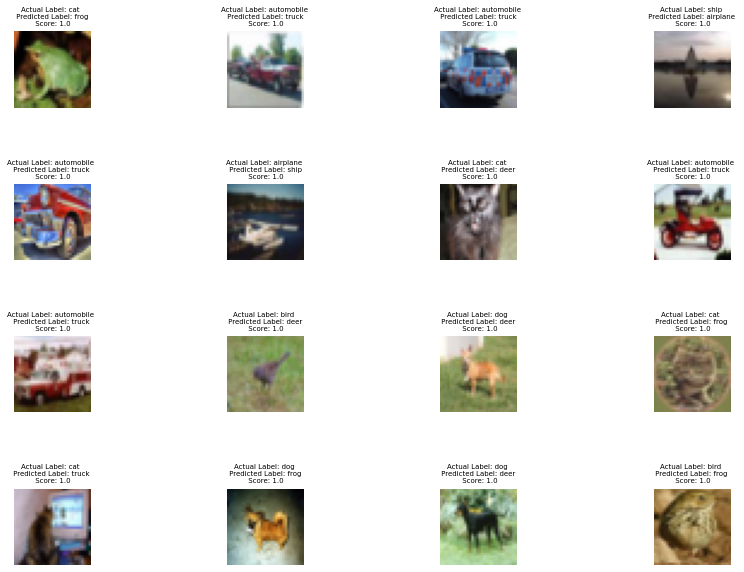

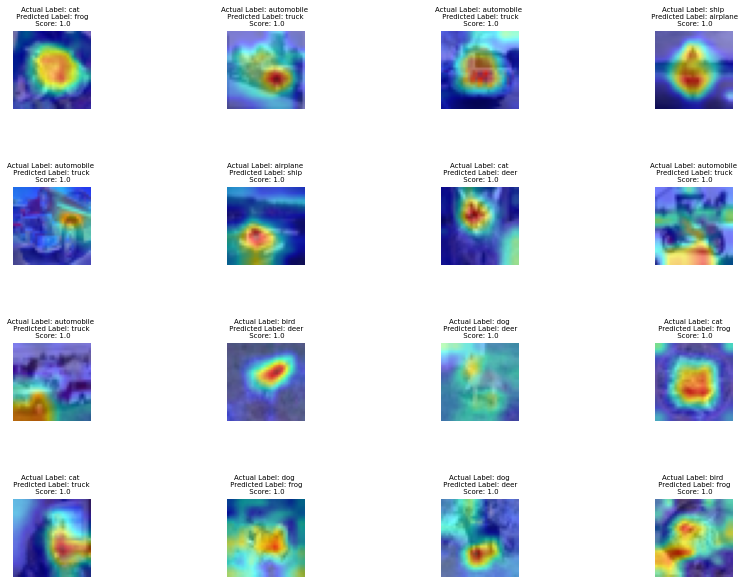

In [15]:
plot.run_prediction(test_loader, ptype="incorrect")

plot.plot(n=16, class_list=classes, grad_cam=False)
plot.plot(n=16, class_list=classes, grad_cam=True)

100%|██████████| 313/313 [00:03<00:00, 92.46it/s] 


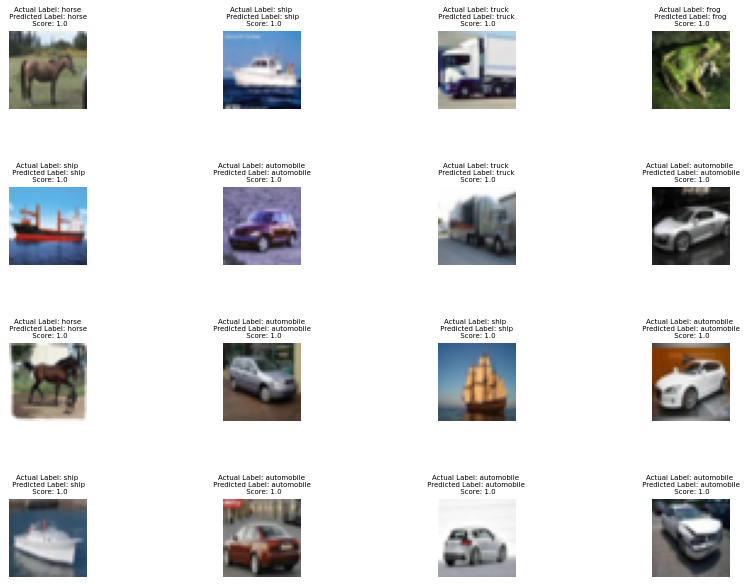

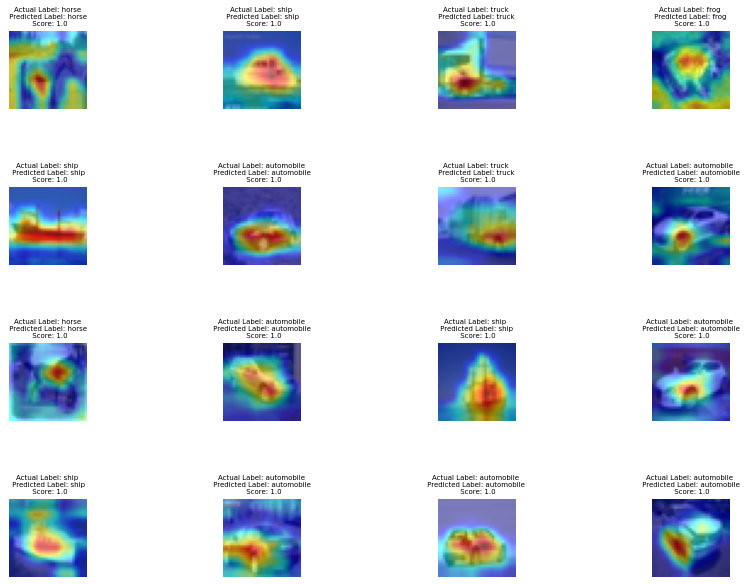

In [16]:
plot.run_prediction(test_loader, ptype="correct")

plot.plot(n=16, class_list=classes, grad_cam=False, reverse=True)
plot.plot(n=16, class_list=classes, grad_cam=True, reverse=True)